In [1]:
import io
import itertools
import numpy as np
import pandas as pd
import os
import re
import string
import tensorflow as tf
import tqdm

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape, BatchNormalization, TimeDistributed
from tensorflow.keras.layers import LSTM, Dense, Activation, Embedding, InputLayer, RepeatVector
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
tf.config.run_functions_eagerly(True)

In [4]:
SEED = 42 
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
# set bool to train a new copy or to load existing model
TRAIN_WORD2VEC = False

In [6]:
# Load text data

In [7]:
df = pd.read_pickle('../../nguyen_vivian_sept_2009_oct_2020.pkl')

In [8]:
text = df['content'].dropna()

In [9]:
text = list(text)

In [10]:
text[:5]

['right now, i am spending time with Brooke, a local partner and we are having a healthy relationship - i look forward to seeing her a lot',
 'i have a code boot camp starting on the 24th',
 'her hair is amazing',
 'All i have is that one I put on instagram.com',
 'I think about you a lot']

In [11]:
# Convert to a dataset

In [12]:
text_ds = tf.data.Dataset.from_tensor_slices(text)

In [13]:
text_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [14]:
# Vectorize the sentences from the corpus

In [15]:
# the vocab size was found from vectorizing the entire text

In [16]:
vocab_size = 51717

In [17]:
vocab_size

51717

In [18]:
# Use the text vectorization layer to normalize, split, and map strings to
# integers. Set output_sequence_length length to pad all samples to same length.
vectorizer = TextVectorization(
    ngrams=2, # make ngrams up to 5 words
    output_mode='int',
    max_tokens=vocab_size,
    output_sequence_length=None)

In [19]:
vectorizer.adapt(text_ds)

/home/vivi/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [20]:
vectorizer

In [21]:
len(vectorizer.get_vocabulary())

51717

In [22]:
# Save the created vocabulary for reference.
inverse_vocab = vectorizer.get_vocabulary()
print(inverse_vocab[:100])

['', '[UNK]', 'i', 'a', 'and', 'to', 'you', 'the', 'of', 'is', 'in', 'my', 'it', 'im', 'for', 'that', 'an', 'with', 'this', 'so', 'me', 'sent', 'but', 'like', 'you sent', 'are', 'was', 'its', 'be', 'have', 'on', 'sent an', 'attachment', 'an attachment', 'one', 'we', 'your', 'out', 'not', 'at', 'just', 'can', 'because', 'if', 'all', 'am', 'do', 'i am', 'what', 'us', 'up', 'get', 'and i', 'dont', 'about', 'when', 'they', 'as', 'or', 'going', 'from', 'one of', 'gay', 'then', 'love', 'want', 'youre', 'good', 'how', 'thats', 'of us', 'i was', 'know', 'to be', 'no', 'really', 'in the', 'her', 'some', 'she', 'go', 'i have', 'into', 'more', 'this is', 'were', 'got', 'us one', 'going to', 'now', 'girls', 'day', 'cute', 'being', 'i dont', 'too', 'also', 'sapphic', 'of the', 'time']


In [23]:
len(inverse_vocab)

51717

In [24]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return tf.squeeze(vectorizer(text))

In [25]:
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_text).unbatch()

In [26]:
text_vector_ds

<_UnbatchDataset shapes: <unknown>, types: tf.int64>

In [27]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

27280


In [28]:
for seq in sequences[:1]:
    print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[  145    89     2    45 14586    99    17  2489     3   931  1334     4
    35    25   853     3  5175   426     2   162   856     5  1416    77
     3   131   412  1160    47 49997 19458 10062 28903 47879  2789 38810
 20838   388   467 49277  3600 50875 42687 20238  1290  8837  7541 30781
 14704 42608   149     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [29]:
len(sequences)

27280

In [30]:
# Preprocessing and prep the words for a word2vec

In [31]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for vocab_size tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence, 
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples 
    # with positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1, 
          num_sampled=num_ns, 
          unique=True, 
          range_max=vocab_size, 
          seed=SEED, 
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      negative_sampling_candidates = tf.expand_dims(
          negative_sampling_candidates, 1)

      context = tf.concat([context_class, negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [32]:
targets, contexts, labels = generate_training_data(
    sequences=sequences, 
    window_size=2, 
    num_ns=4, 
    vocab_size=vocab_size, 
    seed=SEED)
print(len(targets), len(contexts), len(labels))

100%|██████████| 27280/27280 [04:05<00:00, 110.90it/s]

995608 995608 995608


In [33]:
targets[0], contexts[0], labels[0]

(49997,
 <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
 array([[10062],
        [  819],
        [   50],
        [ 6410],
        [  198]])>,
 <tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 0, 0, 0, 0])>)

In [34]:
# Optimize the dataset

In [35]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [36]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: (((1024,), (1024, 5, 1)), (1024, 5)), types: ((tf.int32, tf.int64), tf.int64)>


In [37]:
class Word2Vec(Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = Embedding(vocab_size, 
                                          embedding_dim,
                                          input_length=1,
                                          name="w2v_embedding", )
        self.context_embedding = Embedding(vocab_size, 
                                           embedding_dim, 
                                           )
        self.dots = Dot(axes=(3,2))
        self.flatten = Flatten()

    def call(self, pair):
        target, context = pair
        we = self.target_embedding(target)
        ce = self.context_embedding(context)
        dots = self.dots([ce, we])
        return self.flatten(dots)

In [38]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [39]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2, restore_best_weights=True)

In [40]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
if TRAIN_WORD2VEC == False:
    history = tf.keras.models.load_model('word2vec/')
else:
    history = word2vec.fit(dataset, epochs=20, callbacks=[early_stopping])
    word2vec.save('word2vec/')

In [42]:
try:
    history.model.summary()
except:
    history.summary()

Model: "word2_vec_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
w2v_embedding (Embedding)    multiple                  6619776   
_________________________________________________________________
embedding_2 (Embedding)      multiple                  6619776   
_________________________________________________________________
dot_1 (Dot)                  multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
Total params: 13,239,552
Trainable params: 13,239,552
Non-trainable params: 0
_________________________________________________________________


In [43]:
try:
    weights = history.get_layer('w2v_embedding').get_weights()[0]
except:
    weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
    
vocab = vectorizer.get_vocabulary()

In [44]:
out_v = io.open('my_fb_vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('my_fb_metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if  index == 0: continue # skip 0, it's padding.
    vec = weights[index] 
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [45]:
vocab[:10]

['', '[UNK]', 'i', 'a', 'and', 'to', 'you', 'the', 'of', 'is']

In [46]:
weights

array([[-0.00655227, -0.02306172, -0.00821837, ...,  0.01316669,
        -0.02873637, -0.02686577],
       [-0.02348748, -0.02603285,  0.03295973, ...,  0.03129608,
         0.01464653,  0.03900791],
       [ 0.21162228,  0.23268595, -0.18771759, ...,  0.04561561,
         0.06545863,  0.0117007 ],
       ...,
       [-0.3481354 ,  0.5465079 ,  0.06684943, ..., -0.1219696 ,
        -0.30059358,  0.42635188],
       [-0.06955159,  0.6663448 ,  0.18264799, ..., -0.2669597 ,
        -0.01042631, -0.30537462],
       [ 0.35463333,  0.11982419,  0.3380124 , ...,  0.26325876,
         0.29987538, -0.38265073]], dtype=float32)

In [47]:
weights.shape

(51717, 128)

In [48]:
len(vocab)

51717

In [49]:
# Let's vectorize a sentence and see how it comes out

In [50]:
vectorizer

In [51]:
vectorizer(['uwu into your heart']).numpy()[0, :10]

array([ 359,   82,   36,  543,    1, 3998, 1677])

In [52]:
# for training, we are trying an LSTM to predict the most probable next word.

In [53]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [54]:
np.max([len(i.split()) for i in text])

1631

In [55]:
import matplotlib.pyplot as plt

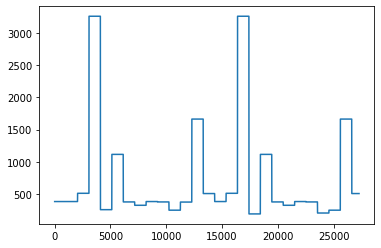

In [56]:
plt.plot([len(i) for i in sequences])

In [57]:
sequences[0][:50]

array([  145,    89,     2,    45, 14586,    99,    17,  2489,     3,
         931,  1334,     4,    35,    25,   853,     3,  5175,   426,
           2,   162,   856,     5,  1416,    77,     3,   131,   412,
        1160,    47, 49997, 19458, 10062, 28903, 47879,  2789, 38810,
       20838,   388,   467, 49277,  3600, 50875, 42687, 20238,  1290,
        8837,  7541, 30781, 14704, 42608])

In [58]:
sequences_processed = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

In [59]:
type(sequences_processed)

numpy.ndarray

In [60]:
sequences_ds = tf.data.Dataset.from_tensor_slices(sequences_processed)

In [61]:
input_dataset = sequences_ds.map(split_input_target)

/home/vivi/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [62]:
input_dataset

<MapDataset shapes: ((3258,), (3258,)), types: (tf.int32, tf.int32)>

In [63]:
# okay, we want to 

# 1. pull up an input string
# 2. create input text and target text
# 3. pull up the vectorized representation of the input and target
# 4. be able to translate the translated vector back into the orignal string by using the inverse_vocab list

In [64]:
text[0]

'right now, i am spending time with Brooke, a local partner and we are having a healthy relationship - i look forward to seeing her a lot'

In [65]:
for input_example, target_example in input_dataset.take(1):
    print('Input data: ', repr(input_example))
    print('Target data:', repr(target_example))

Input data:  <tf.Tensor: shape=(3258,), dtype=int32, numpy=array([145,  89,   2, ...,   0,   0,   0], dtype=int32)>
Target data: <tf.Tensor: shape=(3258,), dtype=int32, numpy=array([89,  2, 45, ...,  0,  0,  0], dtype=int32)>


In [66]:
# Input
[inverse_vocab[i] for i in [  145,    89,     2,    45, 14586,    99,    17,  2489,     3,
         931]]

['right', 'now', 'i', 'am', 'spending', 'time', 'with', 'brooke', 'a', 'local']

In [67]:
# Target
[inverse_vocab[i] for i in [   89,     2,    45, 14586,    99,    17,  2489,     3,   931]]

['now', 'i', 'am', 'spending', 'time', 'with', 'brooke', 'a', 'local']

In [68]:
# Batch size
BATCH_SIZE = 1

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10

input_dataset = input_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

input_dataset

<BatchDataset shapes: ((1, 3258), (1, 3258)), types: (tf.int32, tf.int32)>

In [69]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 128

# Number of RNN units
hidden_size = 512

In [70]:
def build_model_lstm(vocab_size, weights, embedding_dim, hidden_size, batch_size):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim,
                        batch_input_shape=[batch_size, None],
                        weights=[weights], # use of pretained embeddings
                        trainable=False))
    model.add(BatchNormalization())
    model.add(LSTM(hidden_size, return_sequences=False))
    model.add(RepeatVector(max([len(i) for i in sequences]))) #??Difference between RepeatVector and return_sequences
    model.add(LSTM(hidden_size, return_sequences=True))
    model.add((Dense(vocab_size, activation='softmax')))
    return model

In [71]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size, weights):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None], 
                                 weights=[weights]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [72]:
len(vocab)

51717

In [73]:
weights.shape

(51717, 128)

In [74]:
model = build_model(
    vocab_size=len(vocab),
    weights=weights, 
    embedding_dim=embedding_dim,
    rnn_units=512,
    batch_size=BATCH_SIZE)

In [75]:
'''
model1 = build_model_lstm(
    vocab_size=len(vocab),
    weights=weights, 
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    batch_size=BATCH_SIZE)
    ''';

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 128)            6619776   
_________________________________________________________________
gru (GRU)                    (1, None, 512)            986112    
_________________________________________________________________
dense (Dense)                (1, None, 51717)          26530821  
Total params: 34,136,709
Trainable params: 34,136,709
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Generate a response before training and see what we get out

In [78]:
for input_example_batch, target_example_batch in input_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(1, 3258, 51717) # (batch_size, sequence_length, vocab_size)


In [79]:
target_example_batch

<tf.Tensor: shape=(1, 3258), dtype=int32, numpy=array([[176,  18, 678, ...,   0,   0,   0]], dtype=int32)>

In [80]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [81]:
# as expected it makes absolutely no sense

In [82]:
[inverse_vocab[i] for i in sampled_indices][:20]

['but all',
 'few regrets',
 '44 defines',
 'so intimidatingly',
 'import',
 'feeling like',
 'teach a',
 'my dietary',
 'yummy',
 'email right',
 'lanyard that',
 'adopting your',
 'gets an',
 'do really',
 'gay water',
 'well its',
 'their organization',
 'httpsyoutubeznvbwiib4zc',
 'impacted you',
 'that om']

In [83]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [84]:
target_example_batch

<tf.Tensor: shape=(1, 3258), dtype=int32, numpy=array([[176,  18, 678, ...,   0,   0,   0]], dtype=int32)>

In [85]:
example_batch_predictions

<tf.Tensor: shape=(1, 3258, 51717), dtype=float32, numpy=
array([[[ 0.01653561,  0.00774256, -0.00879101, ..., -0.01646533,
          0.00069658, -0.00804295],
        [ 0.01917293,  0.01396623, -0.00849339, ..., -0.00172709,
          0.01816418, -0.00944359],
        [ 0.01676616,  0.00730059, -0.01666023, ..., -0.00460652,
          0.0092532 , -0.00875979],
        ...,
        [-0.00079449, -0.00083548, -0.00159668, ...,  0.00095064,
         -0.00237894, -0.00173098],
        [-0.00079449, -0.00083548, -0.00159668, ...,  0.00095064,
         -0.00237894, -0.00173098],
        [-0.00079449, -0.00083548, -0.00159668, ...,  0.00095064,
         -0.00237894, -0.00173098]]], dtype=float32)>

In [86]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (1, 3258, 51717)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       10.854308


In [87]:
# https://datascience.stackexchange.com/a/67072
# fixed a weird issue where the loss for the RNN is returning as nan

In [88]:
model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=0.5), loss=loss)

In [89]:
# set up checkpoints

In [90]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [91]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)

In [114]:
tf.keras.models.load_model('gru-generator/')

ValueError: Unknown loss function: loss

In [112]:
try:
    history2 = tf.keras.models.load_model('gru_generator/')
except:
    history2 = model.fit(input_dataset, epochs=5, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/5
    7/27280 [..............................] - ETA: 2:44:00 - loss: 0.0241

KeyboardInterrupt: 

In [108]:
model.save('gru-generator/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: gru-generator/assets


In [115]:
vectorizer('hello')

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([520])>

In [116]:
prediction = history2.model.predict(vectorizer('hello'))

/home/vivi/miniconda3/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [118]:
[print(i) for i in prediction]

[[ -8.854552 -18.56578   -4.1275   ... -17.66016  -18.366346 -19.329975]]


[None]

In [107]:
[int(i) for i in prediction]

TypeError: only size-1 arrays can be converted to Python scalars